# Running the Quantum Volume Algorithm
This example walks through the steps of running the quantum volume algorithm on square matrices. It is intended to mirror Algorithm 1 of https://arxiv.org/pdf/1811.12926.pdf. In general, we will generate a model circuit, classically compute its Heavy Output Group, then run various samplers (currently, ideal and noisy simulators) to evaluate how often they generate Heavy results.

Running simulation with 2 qubits and a depth of 2
    Repetition 1 of 11
        Heavy Set: [0, 2]
        Ideal simulation HOG probability: 0.613
        Noisy simulation HOG probability: 0.601
    Repetition 2 of 11
        Heavy Set: [1, 3]
        Ideal simulation HOG probability: 0.792
        Noisy simulation HOG probability: 0.733
    Repetition 3 of 11
        Heavy Set: [1, 3]
        Ideal simulation HOG probability: 0.806
        Noisy simulation HOG probability: 0.767
    Repetition 4 of 11
        Heavy Set: [1, 2]
        Ideal simulation HOG probability: 0.691
        Noisy simulation HOG probability: 0.676
    Repetition 5 of 11
        Heavy Set: [0, 3]
        Ideal simulation HOG probability: 0.854
        Noisy simulation HOG probability: 0.771
    Repetition 6 of 11
        Heavy Set: [1, 2]
        Ideal simulation HOG probability: 0.713
        Noisy simulation HOG probability: 0.693
    Repetition 7 of 11
        Heavy Set: [1, 2]
        Ideal simulation HOG pr

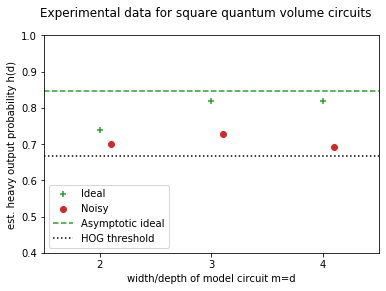

In [101]:
from examples.advanced import quantum_volume
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def generate_chart(depths, average_ideals, average_noisies):
    """Create a chart that is designed to look as similar as possible to
       Figure 2 in https://arxiv.org/pdf/1811.12926.pdf."""
    fig, axs = plt.subplots()
    axs.scatter(depths, average_ideals, marker='+', c='tab:green', label='Ideal')
    axs.scatter([d + .1 for d in depths], average_noisies, c='tab:red', label='Noisy')
    # Line markers for asymptotic ideal heavy output probability and the ideal Heavy Output Generation threshold.
    axs.hlines((1 + np.log(2)) / 2, 0, 100, colors=['tab:green'], label='Asymptotic ideal', linestyles='dashed')
    axs.hlines(2/3, 0, 100, label='HOG threshold', linestyles='dotted')
    # Making the plot look consistent.
    axs.set_ybound(0.4, 1)
    axs.set_xbound(1.5, 4.5)
    axs.xaxis.set_major_locator(plt.MultipleLocator(1))
    axs.set_xlabel("width/depth of model circuit m=d")
    axs.set_ylabel("est. heavy output probability h(d)")
    fig.suptitle('Experimental data for square quantum volume circuits')
    axs.legend(loc='lower left')
    
# Some set-up variables. Feel free to play with these.
num_repetitions = 11 # This is supposed to be >= 100.
depths = range(2, 5) # The depths and number of qubits

# Keep track of the ideal and noisy probabilities.
average_ideals = []
average_noisies = []

for depth in depths:
    num_qubits = depth # Square matrix.
    print(f"Running simulation with {num_qubits} qubits and a depth of {depth}")
    average_ideal = 0
    average_noisy = 0
    for i in range(num_repetitions):
        print(f"    Repetition {i + 1} of {num_repetitions}")
        # Generate a model circuit.
        model_circuit = quantum_volume.generate_model_circuit(
            num_qubits, depth, random_state=np.random.RandomState()
        )
        # Compute its heavy set.
        heavy_set = quantum_volume.compute_heavy_set(model_circuit)
        print(f"        Heavy Set: {heavy_set}")
        
        # Run an ideal simulator over the model circuit.
        ideal = quantum_volume.sample_heavy_set(model_circuit, heavy_set)
        average_ideal += ideal
        print(f"        Ideal simulation HOG probability: {ideal}")

        # Run a noisy simulator over the model circuit.
        noisy = quantum_volume.sample_heavy_set(model_circuit, heavy_set, sampler=cirq.DensityMatrixSimulator(noise=cirq.ConstantQubitNoiseModel(qubit_noise_gate=cirq.DepolarizingChannel(p=0.005))))
        print(f"        Noisy simulation HOG probability: {noisy}")
        average_noisy += noisy
        
        # TODO: The next steps are to compile the model circuit and run it on various devices.

    # Compute the average performance over the total number of runs.
    average_ideal /= num_repetitions
    average_noisy /= num_repetitions
    print(f"    Average ideal HOG probability: {average_ideal}")
    print(f"    Average noisy HOG probability: {average_noisy}")
    average_ideals.append(average_ideal)
    average_noisies.append(average_noisy)

# Create the chart.
generate_chart(depths, average_ideals, average_noisies)